# Evolutionary SVM Kernel Selection
This is a basic bit of code to implement an evolutionary kernel selection for support vector machines. This is created more as a fun project than as a rigorous program, and is created without consultation with relevant literature.

## Sample Data
As a simple sample dataset, the heart failure prediction dataset is used for the time being: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [111]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from random import randint, getrandbits, choices

data = pd.read_csv('./heart.csv')
data = pd.get_dummies(data, drop_first = True, dtype = int)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [112]:
X = data.drop(['HeartDisease'], axis=1)
Y = data['HeartDisease']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=133)

In [113]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [114]:
# Create a custom polynomial kernel function with modifiable coefficients
def custom_polynomial_kernel(X, Y=None, degree=3, coef_list=None):
    """
    X: First feature matrix.
    Y: Second feature matrix (optional). If None, Y is set to X (kernel is computed on X alone).
    degree: Degree of the polynomial.
    coef_list: List of custom coefficients for the polynomial terms.
    """
    if Y is None:
        Y = X

    # Compute the linear kernel (dot product)
    K = np.dot(X, Y.T)

    # Apply custom coefficients to polynomial terms
    K_custom = np.zeros_like(K)
    
    for d in range(degree + 1):
        coef = coef_list[d] if coef_list and d < len(coef_list) else 1
        K_custom += coef * (K ** d)
    
    return K_custom

# Evolution Process
Here we will define the evolution process. The genome of each individual is made up of the coefficients of each degree of the polynomial.

## Initializing individuals

In [115]:
num_individuals: int = 10 # Number of individuals in our population
max_degree: int = 5 # Max degree of polynomial kernel
max_coefficient: int = 1000 # Max coefficient (+/-) of polynomial.

individuals: list[list[int]] = []

for x in range(num_individuals - 1):
    individuals.append([])
    for y in range(max_degree + 1):
        individuals[x].append([])
        individuals[x][y] = randint(-max_coefficient,max_coefficient)
    print(individuals[x])


[-477, -627, -436, 406, 702, 341]
[699, 200, 143, -909, 516, -754]
[-363, 133, 496, 351, -704, -219]
[-846, -131, -546, 738, -614, 945]
[596, -46, 431, -273, -794, 573]
[-331, -982, 457, -988, 254, -360]
[-49, -875, -431, -167, -710, -650]
[-957, -514, 150, 116, -197, -760]
[214, 266, -517, 575, 9, -83]


## Evolution Process Definition
To define the fitness, we want a model that runs quickly and that is performative.

In [118]:
from time import process_time

# Calculate the f1score and training time for an individual
def calculate_individual_score(individual:list[int]) -> list[float]:
    model = svm.SVC(kernel = lambda X, Y: custom_polynomial_kernel(X, Y, degree=max_degree, coef_list=individual))
    start = process_time()
    model.fit(X_train,Y_train)
    end = process_time()
    predictions = model.predict(X_test)
    time = end - start
    f1 = float(f1_score(Y_test, predictions))
    return [time,f1]

# Calculate fitness, measured as the likeelihood that the individual should reproduce, for all individuals.
def calculate_fitness(individuals: list[list[int]]) -> list[float]:
    scores: list[list[float]] = []
    fitness: list[float] = []
    f1_max = 0

    time_total: float = 0
    f1_total: float = 0
    for x in individuals:
        score = calculate_individual_score(x)
        scores.append(score)
        time_total += score[0]
        f1_total += score[1]
    
    for x in scores:
        time_score = x[0]/time_total
        f1_score = x[1]/f1_total
        if f1_score > f1_max: f1_max = f1_score
        fitness.append(0.7 * f1_score + 0.3 * time_score) # Make the overall score 70% from performance, 30% from time
    
    print(f1_max)
    return(fitness)    

def offspring(mates:list[list[int]]) -> list[int]:
    new_individual = []
    for x in range(max_degree + 1):
        if (randint(0,100) < 10): # 10% chance of mutation to a random new integer
            new_individual.append(randint(0,100))
        elif (getrandbits(1)):
            new_individual.append(mates[0][x])
        else:
            new_individual.append(mates[1][x])
    
    return new_individual
        

def generate_new_population(individuals:list[list[int]]) -> dict[list[list[int]], float]:
    fitness = calculate_fitness(individuals)
    new_population: list[list[int]] = []

    for x in range(num_individuals - 1):
        mates: list[list[int]] = choices(individuals, weights=fitness, k=2)
        new_population.append(offspring(mates))
    return {"population": new_population, "fitness": max(fitness)}


## Evolution Loop

0.11323010195025564
0.1127095951805956
0.11310102059603165
0.11121938013511982
0.11115775788518573
0.11161584292343144
0.11170877392874264
0.11161584292343144
0.11306264073245277
0.11264007902829488


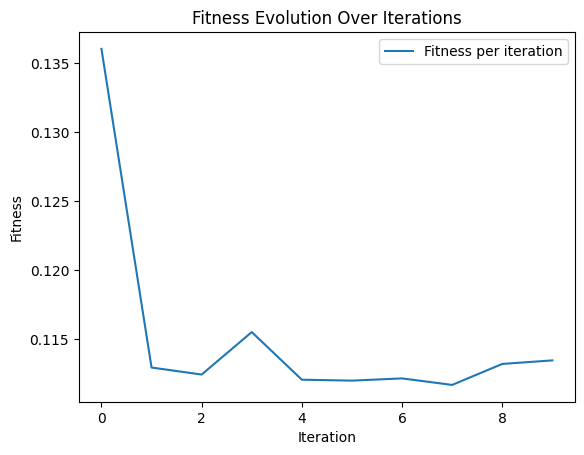

In [120]:
import matplotlib.pyplot as plt


fitnesses: list[float] = []
for x in range(10):
    evolution = generate_new_population(individuals)
    individuals = evolution["population"]
    fitnesses.append(evolution["fitness"])
    
# Plot the fitness values
plt.plot(range(10), fitnesses, label="Fitness per iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Fitness Evolution Over Iterations")
plt.legend()
plt.show()

In [57]:
print(generate_new_population(individuals))



[[-11, 11, -43, 18, -46], [-26, -35, -18, -86, 44], [74, 53, -18, -95, 46], [72, -23, 68, -62, 52], [-26, 12, 32, -86, -85], [-85, -35, -18, 18, 46], [77, 51, 32, 66, 94], [93, 69, 37, 2, 88], [14, 69, 10, -95, -65]]


In [31]:
model = svm.SVC(kernel = lambda X, Y: custom_polynomial_kernel(X, Y, degree=2, coef_list=[10,100,1]))
model.fit(X_train,Y_train)
predictions = model.predict(X_test)
print(f'Accuracy is {accuracy_score(Y_test, predictions)}, Precision is {precision_score(Y_test, predictions)}, Recall is {recall_score(Y_test, predictions)}')

Accuracy is 0.8152173913043478, Precision is 0.8445945945945946, Recall is 0.8169934640522876


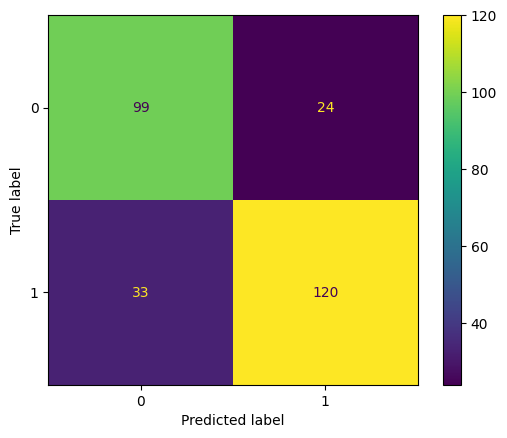

In [112]:
confusion_matrix = confusion_matrix(Y_test, predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()